<a href="https://colab.research.google.com/github/mgnarag/painting_restoration/blob/main/CNN_L_ab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Google drive loading  and function imports

In [2]:
from google.colab import drive
drive.mount("/content/drive")

import os
import contextlib

# Suppress output
with contextlib.redirect_stdout(None):
    os.system('ls drive/My\\ Drive')

file_path = "/content/drive/MyDrive/Baumgartner screenshots/SPIE 2025 new runs/Paintings/"

Mounted at /content/drive


In [3]:
import time
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image, ImageOps
from PIL import Image, ImageDraw
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 236958876
import cv2
from skimage import color

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from tensorflow import keras

from sklearn.model_selection import train_test_split

# 1. Pre-processing: removing the border and spliting the image into train and test

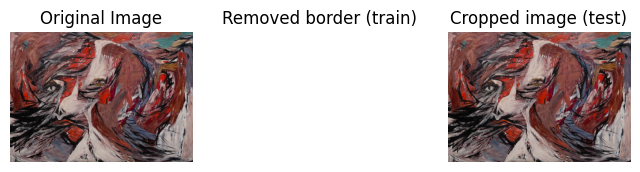

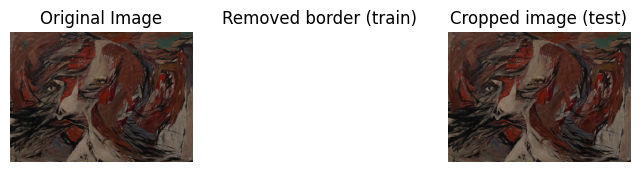

In [4]:
def remove_border(image):
    # Crop from right and bottom to make divisible by 8
    width, height = image.size
    new_width = width - (width % 8)
    new_height = height - (height % 8)
    image = image.crop((0, 0, new_width, new_height))

    # Define the crop size
    crop_pixels = 0
    width, height = image.size

    # Create an empty transparent image
    border_only = Image.new("RGBA", (width, height), (255, 255, 255, 0))

    # Paste the original image onto the border_only image
    border_only.paste(image)

    # Now make the center area transparent
    draw = ImageDraw.Draw(border_only)
    draw.rectangle(
        [crop_pixels, crop_pixels, width - crop_pixels, height - crop_pixels],
        fill=(255, 255, 255, 0))

    # Crop the center image (cropped version)
    cropped_image = image.crop((
        crop_pixels,            # left
        crop_pixels,            # top
        width - crop_pixels,     # right
        height - crop_pixels     # bottom
    ))

    # Display the original, cropped, and removed border
    fig, axs = plt.subplots(1, 3, figsize=(8, 4))

    # Original Image
    axs[0].imshow(image)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # Removed Border
    axs[1].imshow(border_only)
    axs[1].set_title('Removed border (train)')
    axs[1].axis('off')

    # Cropped Image
    axs[2].imshow(cropped_image)
    axs[2].set_title('Cropped image (test)')
    axs[2].axis('off')

    plt.show()

    cropped_image.save(file_path+"test/"+painting_name+"_test.png")       # Save the cropped center
    border_only.save(file_path+"train/"+painting_name+"_train.png")
    return border_only

 # Load the image
painting_name = '[13-After]'
after_train = remove_border(Image.open(file_path+painting_name+".png"))
painting_name = '[13-Before]'
before_train = remove_border(Image.open(file_path+painting_name+".png"))

# 2. Define relevant functions

In [5]:
def rgb_lab_normalized(im):
    rgb_array = np.array(im) # Convert to numpy array
    rgb_array_normalized = rgb_array / 255.0 # Normalize RGB values from 0 to 1
    lab_array_normalized = color.rgb2lab(rgb_array_normalized) # Convert RGB to LAB colorspace
    lab_array_normalized[..., 0] = (lab_array_normalized[..., 0]) / 100.0 # Scale LAB values to range [0, 1]
    lab_array_normalized[..., 1] = (lab_array_normalized[..., 1] + 128) / 255.0
    lab_array_normalized[..., 2] = (lab_array_normalized[..., 2] + 128) / 255.0
    lab_image_normalized = Image.fromarray((lab_array_normalized * 255).astype(np.uint8), mode='LAB')# Convert LAB array back to image
    return lab_image_normalized

    import tensorflow as tf
from keras.saving import register_keras_serializable

@register_keras_serializable()
def color_loss(y_true, y_pred):
    # Scale from [0,1] to [0,255]
    y_true = y_true * 255.0
    y_pred = y_pred * 255.0

    # Convert RGB to LAB
    y_true_lab = rgb_to_lab(y_true)
    y_pred_lab = rgb_to_lab(y_pred)

    # Separate L, a, b channels
    L1, a1, b1 = tf.split(y_true_lab, 3, axis=-1)
    L2, a2, b2 = tf.split(y_pred_lab, 3, axis=-1)

    # Delta calculations
    delta_L = L1 - L2
    delta_a = a1 - a2
    delta_b = b1 - b2

    delta_e = tf.sqrt(delta_L**2 + delta_a**2 + delta_b**2)

    return tf.reduce_mean(delta_e)

def rgb_to_lab(srgb):
    srgb = tf.clip_by_value(srgb, 0.0, 255.0)
    srgb = srgb / 255.0

    # Convert sRGB to XYZ
    def f(c):
        return tf.where(c > 0.04045, tf.pow((c + 0.055) / 1.055, 2.4), c / 12.92)
    rgb = f(srgb)

    rgb = tf.reshape(rgb, [-1, 3])
    matrix = tf.constant([
        [0.4124564, 0.3575761, 0.1804375],
        [0.2126729, 0.7151522, 0.0721750],
        [0.0193339, 0.1191920, 0.9503041],
    ], dtype=tf.float32)
    xyz = tf.matmul(rgb, matrix)
    xyz = tf.reshape(xyz, tf.shape(srgb))

    # Normalize for D65 white point
    xyz_ref = [0.95047, 1.0, 1.08883]
    xyz = xyz / xyz_ref

    def f_lab(t):
        delta = 6/29
        return tf.where(t > delta**3, tf.pow(t, 1/3), t / (3 * delta**2) + 4/29)

    f_xyz = f_lab(xyz)

    L = 116 * f_xyz[..., 1] - 16
    a = 500 * (f_xyz[..., 0] - f_xyz[..., 1])
    b = 200 * (f_xyz[..., 1] - f_xyz[..., 2])

    lab = tf.stack([L, a, b], axis=-1)
    return lab

# SSIM loss function
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

# 3. Preparing the training dataset: cropping small patches

In [6]:
def crop_patches(image):
  # Parameters
  patch_size = 8
  overlap = 4
  stride = patch_size - overlap  # move 4 pixels at a time

  # Get image size
  width, height = image.size

  # List to collect patch arrays
  patches_array = []

  # Loop over the image
  for y in range(0, height - patch_size + 1, stride):
      for x in range(0, width - patch_size + 1, stride):
          # Crop the patch
          patch = image.crop((x, y, x + patch_size, y + patch_size))

          # Check if the patch is fully opaque
          patch_data = np.array(patch)
          if patch_data.shape[2] == 4:  # RGBA
              alpha_channel = patch_data[:, :, 3]
              if not np.all(alpha_channel == 255):
                  continue  # Skip partially transparent patches

              # Keep only RGB channels (drop alpha)
              patch_rgb = patch_data[:, :, :3]
              patch_lab = rgb_lab_normalized(patch_rgb)
              patches_array.append(patch_lab)
              #im1 = np.rot90(patch_lab)
              #patches_array.append(im1)

  # Convert list to NumPy array
  patches_array = np.array(patches_array)/255
  return patches_array

input = crop_patches(before_train)
output = crop_patches(after_train)

print("Done reading the input of size = ", input.shape)
print("Done reading the output of size = ", output.shape)

# Split the data into training and testing sets
train_input, test_input, train_output, test_output = train_test_split(
    input, output, test_size=0.2, random_state=42)

print("Done reading the train input of size = ", train_input.shape)
print("Done reading the test input of size = ", test_input.shape)
print("Done reading the train output of size = ", train_input.shape)
print("Done reading the test output of size = ", test_input.shape)

input = []
output = []

Done reading the input of size =  (0,)
Done reading the output of size =  (0,)


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

## Add patches

In [11]:
from tqdm import tqdm
# Your cropping function
def crop_patches(image):
    patch_size = 8
    overlap = 4
    stride = patch_size - overlap
    width, height = image.size
    patches_array = []

    for y in range(0, height - patch_size + 1, stride):
        for x in range(0, width - patch_size + 1, stride):
            patch = image.crop((x, y, x + patch_size, y + patch_size))
            patch_data = np.array(patch)

            if patch_data.shape[2] == 4:  # RGBA
                alpha_channel = patch_data[:, :, 3]
                if not np.all(alpha_channel == 255):
                    continue
                patch_rgb = patch_data[:, :, :3]
                patch_lab = rgb_lab_normalized(patch_rgb)
                patches_array.append(patch_lab)
                im1 = np.rot90(patch_lab)
                patches_array.append(im1)
                im1 = np.rot90(im1)
                patches_array.append(im1)
                im1 = np.rot90(im1)
                patches_array.append(im1)
    return np.array(patches_array)

# Set directories
before_dir = file_path + 'train/[13-Before]'
after_dir = file_path + 'train/[13-After]'

# Collect matching file names
file_names = sorted([f for f in os.listdir(before_dir) if f.endswith('.png')])

# Lists for all patches
X_train, Y_train = [], []

# Loop through all matching files
for fname in tqdm(file_names, desc="Processing images"):
    before_path = os.path.join(before_dir, fname)
    after_path = os.path.join(after_dir, fname)

    # Load images with alpha
    before_img = Image.open(before_path).convert("RGBA")
    after_img = Image.open(after_path).convert("RGBA")

    # Crop patches
    before_patches = crop_patches(before_img)
    after_patches = crop_patches(after_img)

    # Sanity check: match counts
    n = min(len(before_patches), len(after_patches))
    X_train.append(before_patches[:n])
    Y_train.append(after_patches[:n])

# Stack all patches
X_train = np.vstack(X_train)/255
Y_train = np.vstack(Y_train)/255

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

# Make sure train_input and train_output already exist and have matching shapes
train_input = np.concatenate([train_input, X_train], axis=0)
train_output = np.concatenate([train_output, Y_train], axis=0)

print("Updated train_input shape:", train_input.shape)
print("Updated train_output shape:", train_output.shape)


Processing images: 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]

X_train shape: (36596, 8, 8, 3)
Y_train shape: (36596, 8, 8, 3)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

In [12]:
input = X_train
output = Y_train

# Split the data into training and testing sets
train_input, test_input, train_output, test_output = train_test_split(
    input, output, test_size=0.2, random_state=42)

print("Done reading the train input of size = ", train_input.shape)
print("Done reading the test input of size = ", test_input.shape)
print("Done reading the train output of size = ", train_input.shape)
print("Done reading the test output of size = ", test_input.shape)

input = []
output = []

Done reading the train input of size =  (29276, 8, 8, 3)
Done reading the test input of size =  (7320, 8, 8, 3)
Done reading the train output of size =  (29276, 8, 8, 3)
Done reading the test output of size =  (7320, 8, 8, 3)


# Finalize  training

In [13]:
train_input_L = train_input[:,:,:,0:1]
train_input_ab = train_input[:,:,:,1:3]
train_output_L = train_output[:,:,:,0:1]
train_output_ab = train_output[:,:,:,1:3]

test_input_L = test_input[:,:,:,0:1]
test_input_ab = test_input[:,:,:,1:3]
test_output_L = test_output[:,:,:,0:1]
test_output_ab = test_output[:,:,:,1:3]

print("Done reading the train input of size = ", train_input.shape)
print("Done reading the test input of size = ", test_input.shape)
print("Done reading the train output of size = ", train_input.shape)
print("Done reading the test output of size = ", test_input.shape)

train_input = []
train_output = []
test_input = []
test_output = []

Done reading the train input of size =  (29276, 8, 8, 3)
Done reading the test input of size =  (7320, 8, 8, 3)
Done reading the train output of size =  (29276, 8, 8, 3)
Done reading the test output of size =  (7320, 8, 8, 3)


## Visualize the patches

In [ ]:
N = 24000
n = 10
plt.figure(figsize=(10, 4))
for i in range(0,10):
    ax = plt.subplot(2, n, i + 1)
    plt.title("input")
    plt.imshow((train_input[i+N]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    bx = plt.subplot(2, n, i + n + 1)
    plt.title("output")
    plt.imshow((train_output[i+N]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

# Train

In [14]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization
from keras.optimizers import Adam
import tensorflow as tf

def unet_model_L(input_shape=(8, 8, 1)):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)

    #conv2 = Conv2D(16, 3, activation='relu', padding='same', strides=2)(conv1)
    #conv2 = Conv2D(16, 3, activation='relu', padding='same')(conv2)

    # Decoder
    #up1 = Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same')(conv2)
    #concat1 = concatenate([up1, conv1])
    #conv3 = Conv2D(8, 3, activation='relu', padding='same')(concat1)
    #conv3 = Conv2D(8, 3, activation='relu', padding='same')(conv3)

    # Output Layer
    output = Conv2D(1, kernel_size=3, activation='sigmoid', padding='same')(conv1)

    model = Model(inputs=inputs, outputs=output)
    return model

unet_L = unet_model_L()
unet_L.summary()
#---------------------------------------------------
def unet_model_ab(input_shape=(8, 8, 2)):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)

    #conv2 = Conv2D(16, 3, activation='relu', padding='same', strides=2)(conv1)
    #conv2 = Conv2D(16, 3, activation='relu', padding='same')(conv2)

    # Decoder
    #up1 = Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same')(conv2)
    #concat1 = concatenate([up1, conv1])
    #conv3 = Conv2D(8, 3, activation='relu', padding='same')(concat1)
    #conv3 = Conv2D(8, 3, activation='relu', padding='same')(conv3)

    # Output Layer
    output = Conv2D(2, kernel_size=3, activation='sigmoid', padding='same')(conv1)

    model = Model(inputs=inputs, outputs=output)
    return model

unet_ab = unet_model_ab()
unet_ab.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8, 8, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 8, 8, 32)       │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 1)        │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,857 (38.50 KB)

 Trainable params: 9,857 (38.50 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 8, 8, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 32)       │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 2)        │           578 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,434 (40.76 KB)

 Trainable params: 10,434 (40.76 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
from keras.optimizers import Adam
from tensorflow.keras import layers, losses

opt = Adam(learning_rate=0.0001)
unet_L.compile(optimizer=opt, loss=losses.MeanSquaredError())
#unet.compile(optimizer=opt, loss=color_loss)
start = time.time()
model = unet_L.fit(train_input_L, train_output_L,
                epochs=100,
                shuffle=True,
                validation_data=(test_input_L, test_output_L),batch_size=32)
end = time.time()


print("The time of execution of above program is :",
      (end-start), "seconds")

unet_L.save(file_path + 'Model/unet_L.keras')

#-----------------------------------------------------
opt = Adam(learning_rate=0.0001)
unet_ab.compile(optimizer=opt, loss=losses.MeanSquaredError())
#unet.compile(optimizer=opt, loss=color_loss)
start = time.time()
model = unet_ab.fit(train_input_ab, train_output_ab,
                epochs=100,
                shuffle=True,
                validation_data=(test_input_ab, test_output_ab),batch_size=32)
end = time.time()

print("The time of execution of above program is :",
      (end-start), "seconds")

unet_ab.save(file_path + 'Model/unet_ab.keras')

Epoch 1/100
915/915 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 0.0248 - val_loss: 0.0057
Epoch 2/100
915/915 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0054 - val_loss: 0.0047
Epoch 3/100
915/915 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0046 - val_loss: 0.0045
Epoch 4/100
915/915 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 5/100
915/915 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 6/100
915/915 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 7/100
915/915 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 8/100
915/915 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 9/100
915/915 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 10/100
915/915 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 11/100
915/915 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 12/100
915/915 ━━

# Test

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
6/6 ━━━━━━━━

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f929c23f810>)

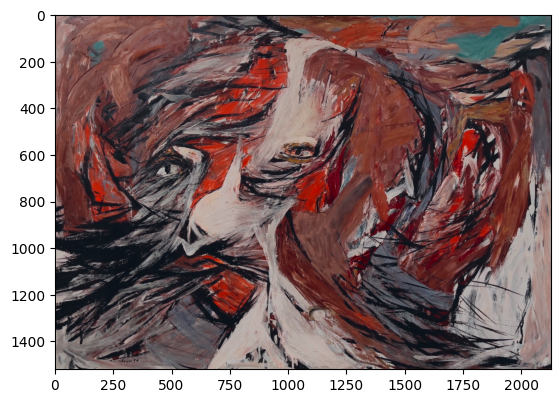

In [16]:
from tensorflow import keras
from PIL import Image, ImageOps
import numpy as np
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 236958876
from keras.models import load_model

n_size = 8
size = 8

def rgb_lab_normalized(im):
    rgb_array = np.array(im) # Convert to numpy array
    rgb_array_normalized = rgb_array / 255.0 # Normalize RGB values from 0 to 1
    lab_array_normalized = color.rgb2lab(rgb_array_normalized) # Convert RGB to LAB colorspace
    lab_array_normalized[..., 0] = (lab_array_normalized[..., 0]) / 100.0 # Scale LAB values to range [0, 1]
    lab_array_normalized[..., 1] = (lab_array_normalized[..., 1] + 128) / 255.0
    lab_array_normalized[..., 2] = (lab_array_normalized[..., 2] + 128) / 255.0
    lab_image_normalized = Image.fromarray((lab_array_normalized * 255).astype(np.uint8), mode='LAB')# Convert LAB array back to image
    return lab_image_normalized

def L_AB_rgb_unnormalized(ab_image, final_L):
    ab_image = ab_image/255.0
    final_L = final_L/255.0
    final_L[..., 0] = final_L[..., 0]*100.0
    ab_image[..., 0] = (ab_image[..., 0] * 255.0) - 128
    ab_image[..., 1] = (ab_image[..., 1] * 255.0) - 128
    LAB_array = np.dstack((final_L, ab_image[:,:,0], ab_image[:,:,1]))
    rgb_array_unnormalized = color.lab2rgb(LAB_array)# Convert LAB to RGB colorspace
    rgb_array_unnormalized = (rgb_array_unnormalized * 255).astype(np.uint8)# Scale RGB values back to the range [0, 255]
    rgb_image_unnormalized = Image.fromarray(rgb_array_unnormalized, mode='RGB')# Convert RGB array back to image
    return rgb_image_unnormalized

def crop_(im):
    width, height = im.size
    data = []
    for j in np.arange(0,int(height/n_size)):
        for i in range(0,int(width/n_size)):
            im1 = im.crop((0 + (n_size*i), 0 + (n_size*j), n_size + (n_size*i), n_size + (n_size*j)))
            im1 = np.array(im1)
            im1 = im1.astype(np.float32)
            data.append(im1)
    return data


#----------------READING THE TEST IMAGE--------------------#
painting_name = '[13-Before]'
test = Image.open(file_path+ "test/" + painting_name+"_test.png").convert('RGB')
test = rgb_lab_normalized(test)
test = ImageOps.expand(test, border=2, fill='black')
w_dirty, h_dirty = test.size
#----------------------------------------------------------#

#----------------GETTING L--------------------#
autoencoder = load_model(file_path + 'Model/unet_L.keras')

xx = int(w_dirty/n_size)
final_L=[]
for portion in np.arange(0,xx):
    im1 = test.crop((n_size*portion, 0, (n_size*portion) + n_size, h_dirty))
    w1, h1 = im1.size
    w = int(w1/n_size)
    h = int(h1/n_size)
    neverbeforeseen = np.array(crop_(im1))
    neverbeforeseen = neverbeforeseen[:,:,:,0:1]
    neverbeforeseen = np.array(neverbeforeseen).astype(np.float32)/255.0
    decoded_imgs = autoencoder.predict(neverbeforeseen)
    #decoded_imgs = decoded_imgs[:, 2:6, 2:6, :]
    col = np.vstack((decoded_imgs[0],decoded_imgs[1]))
    for i in range(2,len(decoded_imgs)):
        col = np.vstack((col,decoded_imgs[i]))
    y = col
    y = (y * 255).astype('uint8')
    if portion == 0:
        final_L = y
    if portion > 0:
        final_L = np.hstack((final_L,y))

#----------------GETTING AB--------------------#
autoencoder = load_model(file_path + 'Model/unet_ab.keras')

xx = int(w_dirty/n_size)
final=[]
for portion in np.arange(0,xx):
    im1 = test.crop((n_size*portion, 0, (n_size*portion) + n_size, h_dirty))
    w1, h1 = im1.size
    w = int(w1/n_size)
    h = int(h1/n_size)
    neverbeforeseen = np.array(crop_(im1))
    neverbeforeseen = neverbeforeseen[:,:,:,1:3]
    neverbeforeseen = np.array(neverbeforeseen).astype(np.float32)/255.0
    decoded_imgs = autoencoder.predict(neverbeforeseen)
    #decoded_imgs = decoded_imgs[:, 2:6, 2:6, :]
    col = np.vstack((decoded_imgs[0],decoded_imgs[1]))
    for i in range(2,len(decoded_imgs)):
        col = np.vstack((col,decoded_imgs[i]))
    y = col
    y = (y * 255).astype('uint8')
    if portion == 0:
        final = y
    if portion > 0:
        final = np.hstack((final,y))



#----------------TEST ON L from model and AB from model--------------------#
final_L_AB = L_AB_rgb_unnormalized(final, final_L)
final_L_AB = np.squeeze(final_L_AB)
reconstructed_L_AB = Image.fromarray(final_L_AB)
reconstructed_L_AB.save(file_path + "test/"+painting_name+"_l_ab.png")
plt.figure(), plt.imshow(reconstructed_L_AB)

## Delta E

In [17]:
import os
import csv
import numpy as np
from skimage import io
import cv2

def delta_e_cie2000(lab1, lab2):
    # Constants
    kL = 1
    kC = 1
    kH = 1

    L1, a1, b1 = lab1
    L2, a2, b2 = lab2

    # CIE 2000 formula
    L_bar_prime = 0.5 * (L1 + L2)
    C1 = np.sqrt(a1**2 + b1**2)
    C2 = np.sqrt(a2**2 + b2**2)
    C_bar = 0.5 * (C1 + C2)
    C_bar7 = C_bar**7

    G = 0.5 * (1 - np.sqrt(C_bar7 / (C_bar7 + 25**7)))
    a1_prime = (1 + G) * a1
    a2_prime = (1 + G) * a2

    C1_prime = np.sqrt(a1_prime**2 + b1**2)
    C2_prime = np.sqrt(a2_prime**2 + b2**2)
    C_bar_prime = 0.5 * (C1_prime + C2_prime)

    h1_prime = np.degrees(np.arctan2(b1, a1_prime)) % 360
    h2_prime = np.degrees(np.arctan2(b2, a2_prime)) % 360

    H_bar_prime = h1_prime + h2_prime
    if abs(h1_prime - h2_prime) > 180:
        H_bar_prime += 360
    H_bar_prime *= 0.5

    T = 1 - 0.17 * np.cos(np.radians(H_bar_prime - 30)) \
        + 0.24 * np.cos(np.radians(2 * H_bar_prime)) \
        + 0.32 * np.cos(np.radians(3 * H_bar_prime + 6)) \
        - 0.20 * np.cos(np.radians(4 * H_bar_prime - 63))

    delta_h_prime = h2_prime - h1_prime
    if abs(delta_h_prime) > 180:
        if h2_prime <= h1_prime:
            delta_h_prime += 360
        else:
            delta_h_prime -= 360

    delta_L_prime = L2 - L1
    delta_C_prime = C2_prime - C1_prime
    delta_H_prime = 2 * np.sqrt(C1_prime * C2_prime) * np.sin(np.radians(delta_h_prime * 0.5))

    S_L = 1 + ((0.015 * (L_bar_prime - 50) ** 2) / np.sqrt(20 + (L_bar_prime - 50) ** 2))
    S_C = 1 + 0.045 * C_bar_prime
    S_H = 1 + 0.015 * C_bar_prime * T

    delta_theta = 30 * np.exp(-(((H_bar_prime - 275) / 25) ** 2))
    R_C = 2 * np.sqrt(C_bar7 / (C_bar7 + 25**7))
    R_T = -R_C * np.sin(2 * np.radians(delta_theta))

    delta_E = np.sqrt(
        (delta_L_prime / (kL * S_L)) ** 2 +
        (delta_C_prime / (kC * S_C)) ** 2 +
        (delta_H_prime / (kH * S_H)) ** 2 +
        R_T * (delta_C_prime / (kC * S_C)) * (delta_H_prime / (kH * S_H))
    )

    return delta_E

def color_error(image1_path,image2_path):
    image1 = io.imread(image1_path)
    image2 = io.imread(image2_path)
    # Ensure images are in uint8 format
    if image1.dtype != np.uint8:
        image1 = (image1 * 255).astype(np.uint8)
    if image2.dtype != np.uint8:
        image2 = (image2 * 255).astype(np.uint8)
    # Remove the alpha channel if it exists
    if image1.shape[-1] == 4:
        image1 = image1[..., :3]
    if image2.shape[-1] == 4:
        image2 = image2[..., :3]
    # Ensure the images have the same dimensions
    if image1.shape != image2.shape:
        raise ValueError("Images must have the same dimensions")
    # Convert images to LAB color space
    image1_lab = cv2.cvtColor(image1, cv2.COLOR_RGB2LAB)
    image2_lab = cv2.cvtColor(image2, cv2.COLOR_RGB2LAB)

    # Scale LAB values to match theoretical ranges
    image1_lab = np.copy(image1_lab).astype(np.float64)
    image2_lab = np.copy(image2_lab).astype(np.float64)

    image1_lab[:, :, 0] = image1_lab[:, :, 0] * (100 / 255)  # L channel
    image1_lab[:, :, 1] = image1_lab[:, :, 1] - 128          # a channel
    image1_lab[:, :, 2] = image1_lab[:, :, 2] - 128          # b channel

    image2_lab[:, :, 0] = image2_lab[:, :, 0] * (100 / 255)  # L channel
    image2_lab[:, :, 1] = image2_lab[:, :, 1] - 128          # a channel
    image2_lab[:, :, 2] = image2_lab[:, :, 2] - 128          # b channel

    # Flatten the images for easier processing
    image1_lab_flat = image1_lab.reshape((-1, 3))
    image2_lab_flat = image2_lab.reshape((-1, 3))

    # Compute Delta E 2000 for each pair of pixels
    delta_e_values = np.array([delta_e_cie2000(lab1, lab2) for lab1, lab2 in zip(image1_lab_flat, image2_lab_flat)])
    delta_e_values_mean = np.mean(delta_e_values)
    delta_e_values_std = np.std(delta_e_values)

    # Reshape the delta_e_values to match the image dimensions, if u wanna plot
    delta_e_image = delta_e_values.reshape(image1_lab.shape[:2])
    return delta_e_image,delta_e_values_mean, delta_e_values_std

In [18]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage import io
import numpy as np

gt_path = file_path+"test/[13-After]_test.png"
out_path = file_path+"test/[13-Before]_l_ab.png"

# Get Delta E values
delta_E, delta_e_values_mean,delta_e_values_std = color_error(gt_path, out_path)
print(f"Mean Delta E: {delta_e_values_mean:.2f}")
print(f"Std Delta E: {delta_e_values_std:.2f}")

Mean Delta E: 7.72
Std Delta E: 7.65


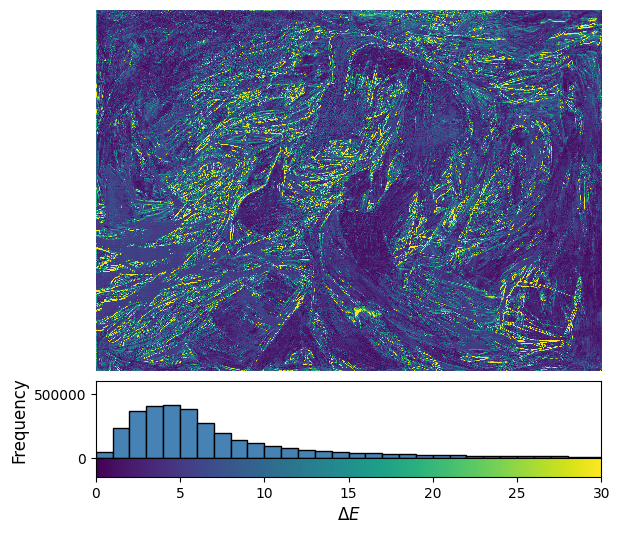

In [19]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Assume delta_E is already defined as a 2D array
# For example:
# delta_E = np.random.rand(512, 512) * 30

# Get image dimensions
h, w = delta_E.shape

# Create figure with width/height proportional to actual image dimensions
fig = plt.figure(figsize=(6, 5.25)) #(5.25, 7)
gs = gridspec.GridSpec(3, 1, height_ratios=[h, int(h * 0.2), int(h * 0.05)], hspace=0.0)

# --- Delta E heatmap ---
ax0 = fig.add_subplot(gs[0])
im = ax0.imshow(delta_E, cmap='viridis', interpolation='nearest', vmin=0, vmax=30)
ax0.axis('off')

# --- Histogram ---
ax1 = fig.add_subplot(gs[1])
ax1.hist(delta_E.ravel(), bins=30, range=(0, 30), color='steelblue', edgecolor='black')
#ax1.invert_yaxis()
ax1.set_xlim(0, 30)
ax1.set_ylim(0, 600000)
ax1.set_ylabel('Frequency', fontsize=12)
#ax1.tick_params(axis='both', labelsize=12)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# --- Horizontal colorbar (no ticks or labels) ---
ax_cb = fig.add_subplot(gs[2])
cbar = fig.colorbar(im, cax=ax_cb, orientation='horizontal')
cbar.set_label('$\\Delta E$', fontsize=12)
#cbar.set_ticks([])
#cbar.set_ticklabels([])

# Remove extra whitespace
plt.tight_layout(pad=0)
plt.show()
